In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

import tensorflow as tf

The following cells retrieve the personal api key stored in `data/api_key.txt`. which can be claimed [here](https://www.alphavantage.co/support/#api-key). 

In [41]:
def api_key():
  # Read api_key.txt and return api_key
  try:
    with open('data/api_key.txt') as fp:
      line = fp.readline()
  except:
    raise RuntimeError('Error while attempting to read data/api_key.txt')
  return line.strip()

In [42]:
def get_data(symbol=None):
  if symbol is None: 
    raise ValueError('No symbol has been provided')
  payload = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': symbol,
    'outputsize': 'full',
    'datatype': 'json',
    'apikey': api_key(), 
    }
  api_url = 'https://www.alphavantage.co/query'
  try:
    response = requests.get(api_url, params=payload)
  except:
    raise ValueError('No response using api key: ' + api_key)
  query = response.json()
  data = query['Time Series (Daily)']
    
  return data

In [43]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [62]:
def json_reader(data):
  time_step = []
  prices = []

  step = 1

  for date in data:
    time_step.append(step)
    step += 1
    prices.append(float(data[date]['4. close']))

  series = np.array(prices[::-1])
  time = np.array(time_step)
  return series, time

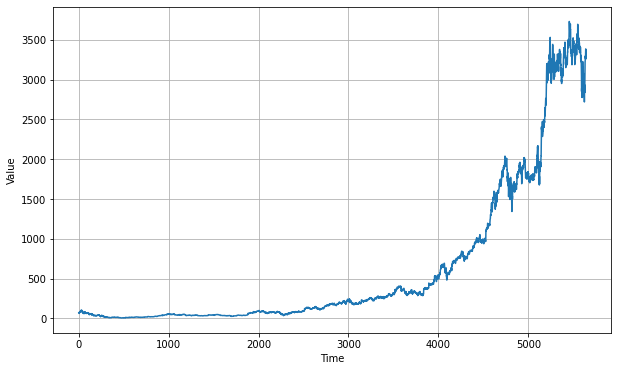

In [63]:
data = get_data('AMZN')
series, time = json_reader(data)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [64]:
split_time = 5000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [66]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [67]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(5000,)
Epoch 1/100
20/20 [==============================] - 12s 353ms/step - loss: 322.2603 - mae: 322.7599 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 7s 353ms/step - loss: 317.2571 - mae: 317.7565 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 7s 354ms/step - loss: 310.3290 - mae: 310.8283 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 7s 359ms/step - loss: 303.7800 - mae: 304.2794 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 7s 351ms/step - loss: 297.2269 - mae: 297.7263 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 7s 351ms/step - loss: 289.3337 - mae: 289.8331 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 8s 401ms/step - loss: 280.0322 - mae: 280.5315 - lr: 1.9953e-08
Epoch 8/100


(1e-08, 0.0001, 0.0, 1000.0)

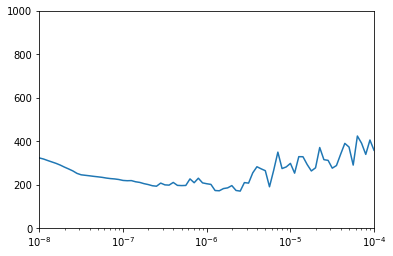

In [69]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
50/50 [==============================] - 12s 143ms/step - loss: 264.0767 - mae: 264.5745
Epoch 2/500
50/50 [==============================] - 7s 145ms/step - loss: 225.1513 - mae: 225.6474
Epoch 3/500
50/50 [==============================] - 7s 143ms/step - loss: 214.5956 - mae: 215.0946
Epoch 4/500
50/50 [==============================] - 7s 142ms/step - loss: 206.4618 - mae: 206.9605
Epoch 5/500
50/50 [==============================] - 7s 142ms/step - loss: 207.2593 - mae: 207.7584
Epoch 6/500
50/50 [==============================] - 7s 141ms/step - loss: 237.9806 - mae: 238.4796
Epoch 7/500
50/50 [==============================] - 7s 142ms/step - loss: 232.7797 - mae: 233.2787
Epoch 8/500
50/50 [==============================] - 7s 143ms/step - loss: 197.9956 - mae: 198.4944
Epoch 9/500
50/50 [==============================] - 7s 142ms/step - loss: 233.8132 - mae: 234.3113
Epoch 10/500
50/50 [==============================] - 7s 142ms/step - loss: 203.2337 - mae: 203.732

In [71]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

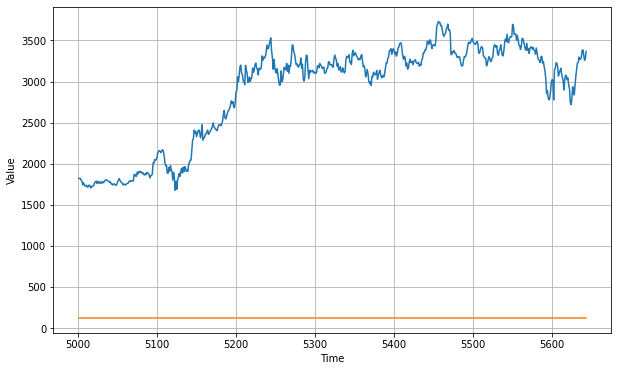

In [72]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)